In [1]:
import tensorflow as tf

In [2]:
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np


AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
def read_image_filenames(data_dir):
    
    person_dir = data_dir + 'person/'
    comic_dir = data_dir + 'comic/'
    
    person_filenames = tf.constant([person_dir + fn for fn in os.listdir(person_dir)])
    comic_filenames = tf.constant([comic_dir + fn for fn in os.listdir(comic_dir)])
    
    person_labels = tf.zeros(person_filenames.shape, dtype=tf.int32)
    comic_labels = tf.ones(comic_filenames.shape, dtype=tf.int32)
    
    return person_filenames, person_labels, comic_filenames, comic_labels

In [11]:
train_data_dir = './person2comic/train_'
test_data_dir = './person2comic/test_'
train_file_persons, train_person_labels, train_file_comics, train_comic_labels = read_image_filenames(train_data_dir)
test_file_persons, test_person_labels, test_file_comics, test_comic_labels = read_image_filenames(test_data_dir)

train_persons = tf.data.Dataset.from_tensor_slices((train_file_persons, train_person_labels))
train_comics = tf.data.Dataset.from_tensor_slices((train_file_comics, train_comic_labels))
test_persons = tf.data.Dataset.from_tensor_slices((test_file_persons, test_person_labels))
test_comics = tf.data.Dataset.from_tensor_slices((test_file_comics, test_comic_labels))

# sub_dataset1 = train_persons.take(3)
# sub_dataset2 = test_comics.take(3)

# for x1, y1 in sub_dataset1:
#     print(x1.numpy(), y1.numpy())
# for x2, y2 in sub_dataset2:
#     print(x2.numpy(), y2.numpy())

In [12]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [13]:
def load_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

# sub_dataset = train_comics.take(3)

# for x, y in sub_dataset:
#     image = load_image(x.numpy())
#     print(image.shape, y.shape)
#     imshow(image)
#     plt.show()
#     image = random_jitter(image)
#     print(image.shape)
#     imshow(image)
#     plt.show()
#     image = normalize(image)
#     print(image.shape)
#     imshow(image)
#     plt.show()

In [14]:
def random_crop(image):
    cropped_image = tf.image.random_crop(image,size=[IMG_HEIGHT,IMG_WIDTH,3])
    return cropped_image

def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def random_jitter(image):
    image = tf.image.resize(image, [286,286],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = random_crop(image)
    image = tf.image.random_flip_left_right(image)
    
    return image

def preprocess_image_train(filename, label):
    image = load_image(filename)
    image = random_jitter(image)
    image = normalize(image)
    return image

def preprocess_image_test(filename, label):
    image = load_image(filename)
    image = normalize(image)
    return image

In [15]:
train_persons = train_persons.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)
train_comics = train_comics.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)
test_persons = test_persons.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)
test_comics = test_comics.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

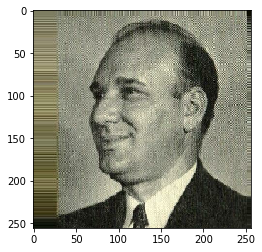

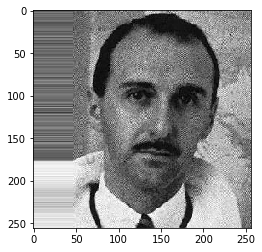

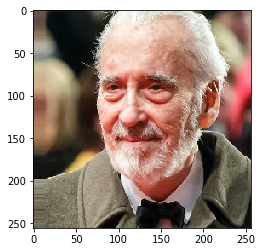

In [16]:
sub_dataset = train_persons.take(3)

for x in sub_dataset:
    imshow(x*0.5+0.5)
    plt.show()

## 输入管线

本教程训练一个模型，以将普通马图片转换为斑马图片。您可以在[此处](https://tensorflow.google.cn/datasets/datasets#cycle_gan)获取该数据集以及类似数据集。

如[论文](https://arxiv.org/abs/1703.10593)所述，将随机抖动和镜像应用到训练集。这是一些避免过拟合的图像增强技术。

这类似于 [pix2pix](https://tensorflow.google.cn/tutorials/generative/pix2pix#load_the_dataset) 中所做的工作。

* 在随机抖动中，图片大小调整为 `286 x 286`，随后被随机裁剪为 `256 x 256`。
* 在随机镜像中，图片会从左到右随机翻转。

In [17]:
sample_person = next(iter(train_persons))
sample_comic= next(iter(train_comics))

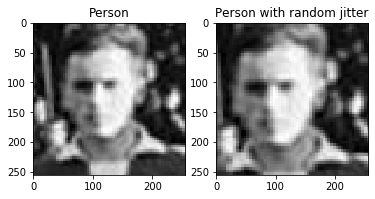

In [18]:
plt.subplot(121)
plt.title('Person')
plt.imshow(sample_person[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Person with random jitter')
plt.imshow(random_jitter(sample_person[0]) * 0.5 + 0.5)

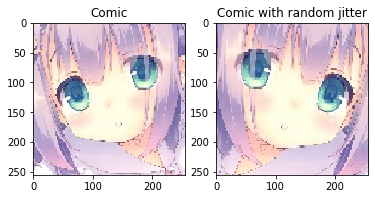

In [19]:
plt.subplot(121)
plt.title('Comic')
plt.imshow(sample_comic[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Comic with random jitter')
plt.imshow(random_jitter(sample_comic[0]) * 0.5 + 0.5)

## 导入并重用 Pix2Pix 模型

通过安装的 [tensorflow_examples](https://github.com/tensorflow/examples) 包导入 [Pix2Pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) 中的生成器和判别器。

本教程中使用模型体系结构与 [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) 中所使用的非常相似。一些区别在于：

* Cyclegan 使用 [instance normalization（实例归一化）](https://arxiv.org/abs/1607.08022)而不是 [batch normalization （批归一化）](https://arxiv.org/abs/1502.03167)。
* [CycleGAN 论文](https://arxiv.org/abs/1703.10593)使用一种基于 `resnet` 的改进生成器。简单起见，本教程使用的是改进的 `unet` 生成器。

这里训练了两个生成器（G 和 F）以及两个判别器（X 和 Y）。

* 生成器 `G` 学习将图片 `X` 转换为 `Y`。 $(G: X -> Y)$
* 生成器 `F` 学习将图片 `Y` 转换为 `X`。 $(F: Y -> X)$
* 判别器 `D_X` 学习区分图片 `X` 与生成的图片 `X` (`F(Y)`)。
* 判别器 `D_Y` 学习区分图片 `Y` 与生成的图片 `Y` (`G(X)`)。

![Cyclegan 模型](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cyclegan_model.png?raw=1)

In [20]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


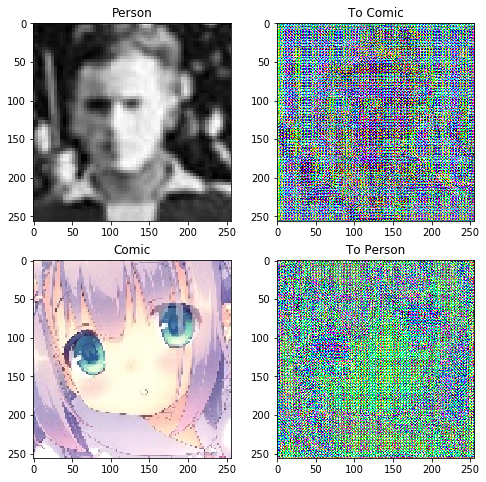

In [21]:
to_comic = generator_g(sample_person)
to_person = generator_f(sample_comic)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_person, to_comic, sample_comic, to_person]
title = ['Person', 'To Comic', 'Comic', 'To Person']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

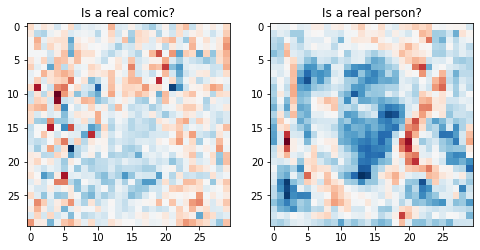

In [22]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real comic?')
plt.imshow(discriminator_y(sample_comic)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real person?')
plt.imshow(discriminator_x(sample_person)[0, ..., -1], cmap='RdBu_r')

plt.show()

## 损失函数

在 CycleGAN 中，没有可训练的成对数据，因此无法保证输入 `x` 和 目标 `y` 数据对在训练期间是有意义的。所以为了强制网络学习正确的映射，作者提出了循环一致损失。

判别器损失和生成器损失和 [pix2pix](https://google.tensorflow.cn/tutorials/generative/pix2pix#define_the_loss_functions_and_the_optimizer) 中所使用的类似。

In [23]:
LAMBDA = 10

In [24]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [25]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)

    generated_loss = loss_obj(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

In [26]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

循环一致意味着结果应接近原始输出。例如，将一句英文译为法文，随后再从法文翻译回英文，最终的结果句应与原始句输入相同。

在循环一致损失中，

* 图片 $X$ 通过生成器 $G$ 传递，该生成器生成图片 $\hat{Y}$。
* 生成的图片 $\hat{Y}$ 通过生成器 $F$ 传递，循环生成图片 $\hat{X}$。
* 在 $X$ 和 $\hat{X}$ 之间计算平均绝对误差。

$$forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$$

$$backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$$


![循环损失](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cycle_loss.png?raw=1)

In [27]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
    return LAMBDA * loss1

如上所示，生成器 $G$ 负责将图片 $X$ 转换为 $Y$。一致性损失表明，如果您将图片 $Y$ 馈送给生成器 $G$，它应当生成真实图片 $Y$ 或接近于 $Y$ 的图片。

$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [28]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

为所有生成器和判别器初始化优化器。

In [29]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [30]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果存在检查点，恢复最新版本检查点
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

## 训练

注意：本示例模型比论文中训练了更少的 epoch（本示例为 40 epoch，论文中为 200 epoch），以使训练时间相对于本教程是合理的。预测的准确率可能会低一些。

In [31]:
EPOCHS = 10

In [32]:
def generate_images(model, test_input):
    prediction = model(test_input)
    
    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # 获取范围在 [0, 1] 之间的像素值以绘制它。
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

尽管训练循环看起来很复杂，其实包含四个基本步骤：

* 获取预测。
* 计算损失值。
* 使用反向传播计算损失值。
* 将梯度应用于优化器。

In [33]:
@tf.function
def train_step(real_x, real_y):
    # persistent 设置为 Ture，因为 GradientTape 被多次应用于计算梯度。
    with tf.GradientTape(persistent=True) as tape:
        # 生成器 G 转换 X -> Y。
        # 生成器 F 转换 Y -> X。

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x 和 same_y 用于一致性损失。
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # 计算损失。
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # 总生成器损失 = 对抗性损失 + 循环损失。
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

        # 计算生成器和判别器损失。
        generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                            generator_g.trainable_variables)
        generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                            generator_f.trainable_variables)

        discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                                discriminator_x.trainable_variables)
        discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                                discriminator_y.trainable_variables)

        # 将梯度应用于优化器。
        generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                                generator_g.trainable_variables))

        generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                                generator_f.trainable_variables))

        discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                    discriminator_x.trainable_variables))

        discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                    discriminator_y.trainable_variables))

In [34]:
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_persons, train_comics)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print ('.', end='')
        n+=1

    clear_output(wait=True)
    # 使用一致的图像（sample_person），以便模型的进度清晰可见。
    generate_images(generator_g, sample_person)

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

ResourceExhaustedError:  OOM when allocating tensor with shape[1,256,32,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/sequential_2/instance_normalization_1/mul_1 (defined at C:\Users\grlzjl\anaconda3\envs\tf2gpu\lib\site-packages\tensorflow_examples\models\pix2pix\pix2pix.py:185) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_step_35772]

Errors may have originated from an input operation.
Input Source operations connected to node model/sequential_2/instance_normalization_1/mul_1:
 model/sequential_2/instance_normalization_1/mul (defined at C:\Users\grlzjl\anaconda3\envs\tf2gpu\lib\site-packages\tensorflow_examples\models\pix2pix\pix2pix.py:184)

Function call stack:
train_step


## 使用测试数据集进行生成

In [ ]:
# 在测试数据集上运行训练的模型。
for inp in test_horses.take(5):
    generate_images(generator_g, inp)

## 下一步
本教程展示了如何从 [Pix2Pix](https://tensorflow.google.cn/tutorials/generative/pix2pix) 教程实现的生成器和判别器开始实现 CycleGAN。 下一步，您可以尝试使用一个来源于 [TensorFlow 数据集](https://tensorflow.google.cn/datasets/datasets#cycle_gan)的不同的数据集。

您也可以训练更多的 epoch 以改进结果，或者可以实现[论文](https://arxiv.org/abs/1703.10593)中所使用的改进 ResNet 生成器来代替这里使用的 U-Net 生成器。